# Gait Cycle defined by bbox

This file used to compare the splitted gait cycel index with different method.  
The target of the gait defined module is to find the max distance between the two foot keypoints in one gait cycle.

Here have 3 method to split the gait cycle:

1. Using the bbox of the human body width (max width) to split the gait cycle.
2. Using the foot keypoints to split the gait cycle.
3. Mix the bbox and foot keypoints to split the gait cycle.

For the results metrics, we use *Euclidean Distance* to calculate the difference between the gait cycle index and ground truth with different method.


In [150]:
import json

# video_name = "LCS_HipOA/20170731_LCS_lat_V1-0001.json"
# video_name = "ASD/20160120_ASD_lat__V1-0001.json"
video_name = "DHS/20160927_DHS_lat_V1-0001.json"
# video_name = "LCS_HipOA/20180806_2_HipOA_lat_V1-0001.json"

# mix method
with open("/workspace/data/segmentation_dataset_512/json_mix/" + video_name, "r") as f:
    mix_method = json.load(f)

# bbox method
with open("/workspace/data/segmentation_dataset_512/json_bbox/" + video_name) as f:
    bbox_method = json.load(f)

# pose method
with open("/workspace/data/segmentation_dataset_512/json_pose/" + video_name) as f:
    pose_method = json.load(f)


print(f'mix method: {mix_method["gait_cycle_index"]}')
print(f'bbox method: {bbox_method["gait_cycle_index_bbox"]}')
print(f'pose method: {pose_method["gait_cycle_index"]}')

mix method: [0, 15, 30, 46, 62, 79, 94, 111, 120]
bbox method: [0, 15, 30, 46, 62, 79, 94, 111, 120]
pose method: [0, 14, 30, 46, 62, 79, 95, 111]


In [147]:
def calc_ed(pred, ground_truth):
	# subtracting vector
	temp = pred - ground_truth

	# doing dot product for finding sum of the squares
	sum_sq = np.dot(temp.T, temp)

	# Doing squareroot and printing Euclidean distance
	# print(np.sqrt(sum_sq) / len(pose))
	return np.sqrt(sum_sq) / len(pose)


In [90]:
mix_method["video_path"]

'/workspace/data/segmentation_dataset_512/fold0/train/ASD_not/20160927_DHS_lat_V1-0001.mp4'

In [148]:
# Python code to find Euclidean distance
# LCS

import numpy as np

# ground_truth = np.array([0, 39, 74, 108, 136, 168, 198, 221])

bbox = np.array([0, 50, 80, 0, 138, 149, 0, 221])
ground_truth = np.array([0, 39, 74, 108, 136, 168, 198, 221])
print(f'(bbox, GT) = {calc_ed(bbox, ground_truth)}')

pose = np.array([0, 18, 29, 74, 85, 108, 136, 147, 168, 198, 209, 0])
ground_truth = np.array([0, 0, 39, 74, 0, 108, 136, 0, 168, 198, 0, 221])
print(f'(pose, GT) = {calc_ed(pose, ground_truth)}')

proposed = np.array([0, 29, 74, 108, 136, 147, 168, 198, 221])
ground_truth = np.array([0, 39, 74, 108, 136, 0, 168, 198, 221])
print(f'(proposed, GT) = {calc_ed(proposed, ground_truth)}')


(bbox, GT) = 25.18818064975008
(pose, GT) = 29.080826061933735
(proposed, GT) = 12.278311954191603


In [149]:
# DHS 
bbox = np.array([0, 15, 30, 46, 62, 79, 94, 111, 120])
pose = np.array([0, 14, 30, 46, 62, 79, 95, 111, 0])
proposed = np.array([0, 14, 30, 46, 62, 79, 95, 111, 120])
ground_truth = np.array([0, 14, 30, 46, 62, 79, 95, 111, 120])


for i in zip(['bbox', 'pose', 'proposed'], [bbox, pose, proposed]):
	print(f'({i[0]}, GT) = {calc_ed(i[1], ground_truth)}')

(bbox, GT) = 0.15713484026367724
(pose, GT) = 13.333333333333334
(proposed, GT) = 0.0


In [155]:
# ASD 

bbox = np.array([0, 12, 24, 37, 50, 61, 69])
pose = np.array([0, 11, 24, 36, 48, 0, 0])
proposed = np.array([0, 11, 24, 37, 50, 61, 69])
ground_truth = np.array([0, 11, 24, 37, 50, 61, 69])

for i in zip(['bbox', 'pose', 'proposed'], [bbox, pose, proposed]):
	print(f'({i[0]}, GT) = {calc_ed(i[1], ground_truth)}')

(bbox, GT) = 0.14285714285714285
(pose, GT) = 13.160702170957789
(proposed, GT) = 0.0


In [156]:
# HipOA 

bbox = np.array([0, 11, 22, 37, 50, 63, 77, 91, 106, 117])
pose = np.array([0, 11, 23, 36, 50, 65, 77, 0, 106, 0])
proposed = np.array([0, 11, 23, 36, 50, 63, 77, 91, 106, 117])
ground_truth = np.array([0, 11, 23, 36, 50, 63, 77, 91, 106, 117])

for i in zip(['bbox', 'pose', 'proposed'], [bbox, pose, proposed]):
	print(f'({i[0]}, GT) = {calc_ed(i[1], ground_truth)}')

(bbox, GT) = 0.1414213562373095
(pose, GT) = 14.82362978490761
(proposed, GT) = 0.0


# Frame for annotation


torch.Size([221, 512, 512, 3])


/tmp/ipykernel_565122/1165753207.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


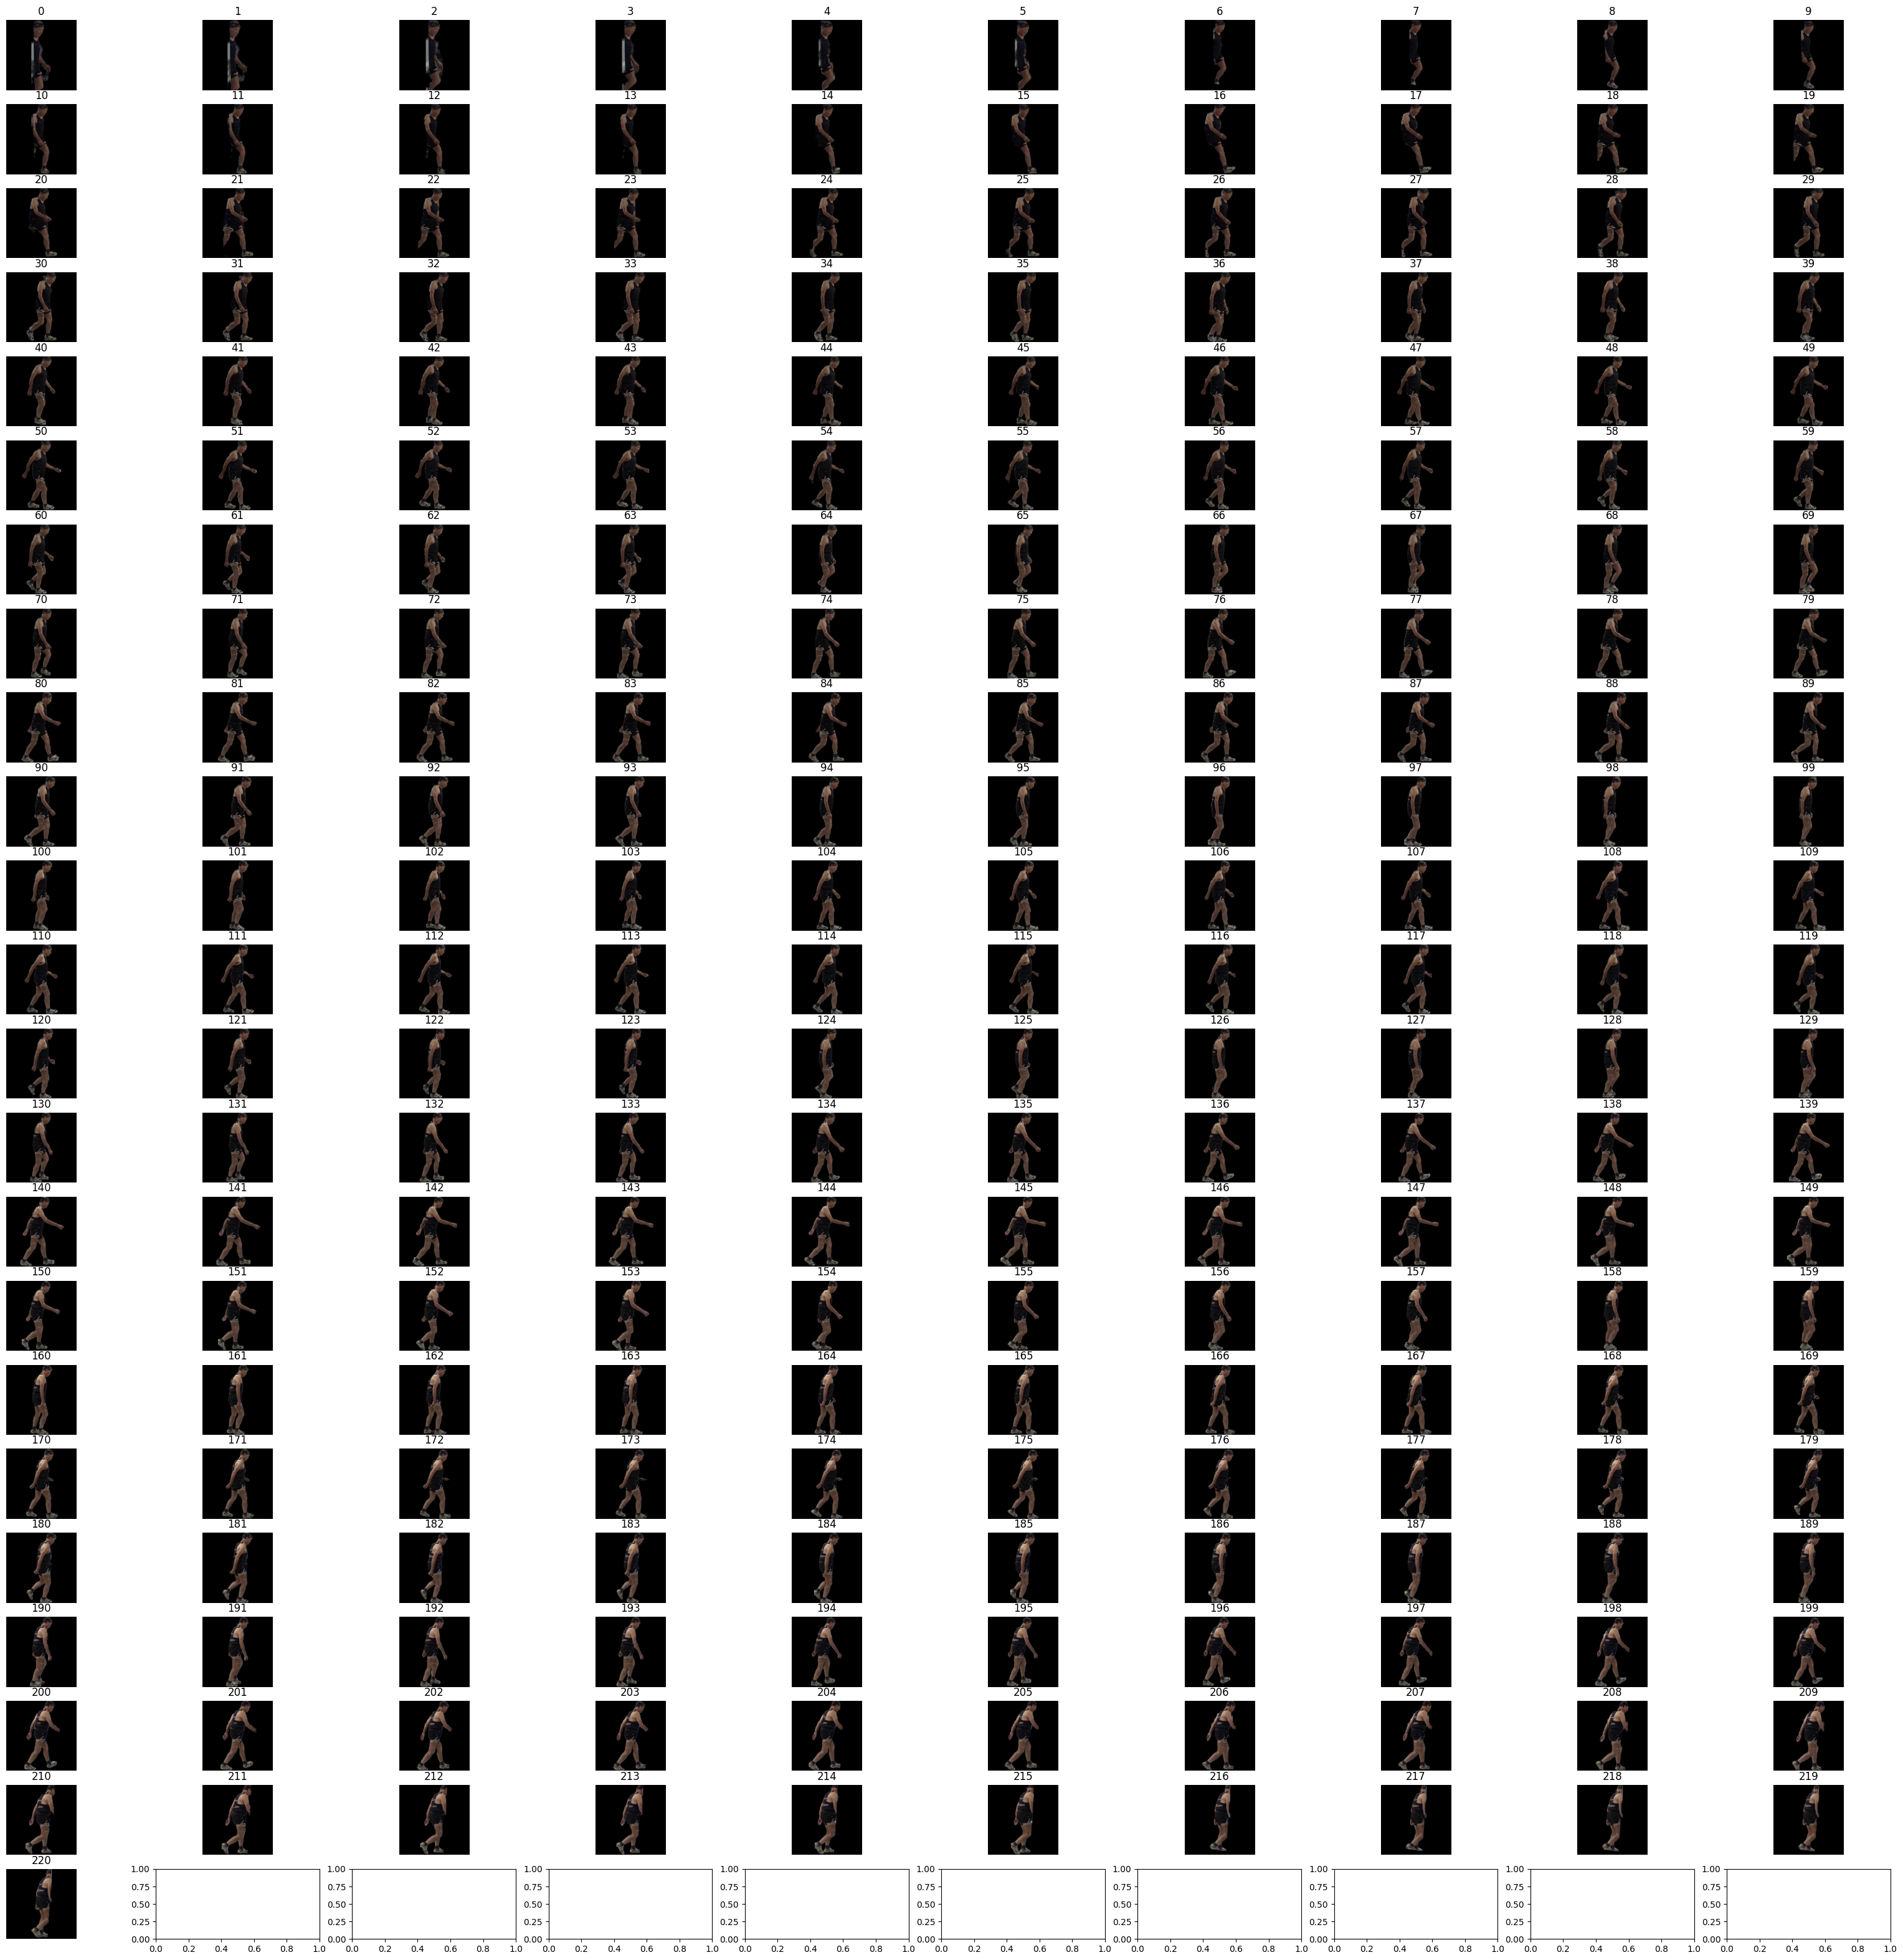

In [127]:
from torchvision.io import read_video
import matplotlib.pyplot as plt
import math 

# load video
video_path = mix_method["video_path"]
vframes, *_ = read_video(video_path, pts_unit="sec", output_format="THWC")
print(vframes.shape)

# save sample to observate

total_frame = vframes.shape[0]
col = 10 
row = math.ceil(total_frame / col)

fig, axes = plt.subplots(row, col, figsize=(40,40))

for r in range(row):
	for num, c in enumerate(range(col)):
		if r*10+c >= total_frame:
			break
		img = vframes[r*10+c]
		ax = axes[r, c]
		ax.imshow(img)
		ax.axis('off')
		ax.set_title(f'{r*10+c}')
fig.show()

# Compare the SSIM of different phase


In [20]:
from skimage.metrics import structural_similarity as ssim
from torchvision.transforms.functional import crop, rgb_to_grayscale, resize, pad

In [21]:
gait_cycle_index = mix_method["gait_cycle_index"]

stance_phase = gait_cycle_index[1:3]
swing_phase = gait_cycle_index[2:4]

stance_phase, swing_phase


([15, 30], [30, 46])

/tmp/ipykernel_565122/579767076.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


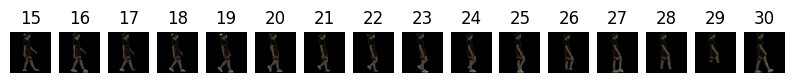

In [22]:
# stance phase 
# 创建子图
fig, axes = plt.subplots(1, int(stance_phase[1] - stance_phase[0]+1), figsize=(10,1))

# 读取并显示每张图像
for num, i in enumerate(range(stance_phase[0], stance_phase[1]+1, 1)):
	img = vframes[i]
	ax = axes[num]
	ax.imshow(img)
	ax.axis('off')
	ax.set_title(f'{i}')

fig.show()

/tmp/ipykernel_565122/4243884219.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


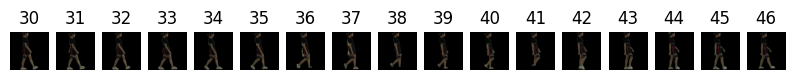

In [23]:
# stance phase 
# 创建子图
fig, axes = plt.subplots(1, int(swing_phase[1] - swing_phase[0]+1), figsize=(10,1))

# 读取并显示每张图像
for num, i in enumerate(range(swing_phase[0], swing_phase[1]+1, 1)):
	img = vframes[i]
	ax = axes[num]
	ax.imshow(img)
	ax.axis('off')
	ax.set_title(f'{i}')

fig.show()

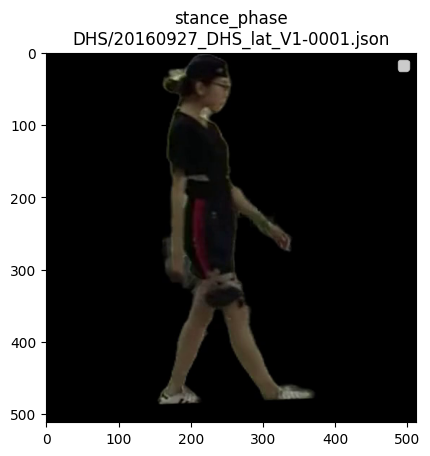

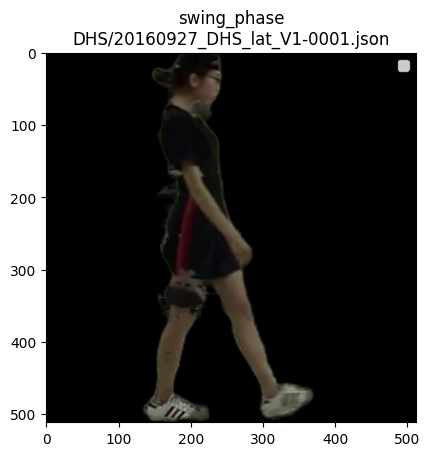

In [24]:
import matplotlib.animation as animation 

def draw_gif(phase, str_phase):

    # 创建一个图形和轴
    fig, ax = plt.subplots()

    # 创建一个函数来更新图形内容
    def update(frame):
        ax.clear()  # 清除轴	;
        img = vframes[frame]  # 读取图像
        ax.legend([f'{frame}'])
        ax.imshow(img)  # 显示图像
        ax.set_title(f'{str_phase}\n{video_name}')

    # 创建动画
    ani = animation.FuncAnimation(fig, update, frames=range(phase[0], phase[1]), interval=1)

    # 保存动画为 GIF 文件
    name = video_name.split('/')[-1].split('.')[0]
    ani.save(f'{name}_{str_phase}_animation.gif', writer='pillow')  # 通过pillow写入GIF

draw_gif(stance_phase, 'stance_phase')
draw_gif(swing_phase, 'swing_phase')

In [25]:
# calc mean ssim cross all frames
ans = []

for i in range(vframes.size()[0]-1):
    
	first_gray = rgb_to_grayscale(vframes[i].permute(2,0,1))
	second_gray = rgb_to_grayscale(vframes[i+1].permute(2,0,1))

	first_gray = resize(first_gray, (256, 256)).squeeze()
	second_gray = resize(second_gray, (256, 256)).squeeze()

	score = ssim(first_gray.numpy(), second_gray.numpy())
	ans.append(score)

np.mean(ans)



/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.8555572014744651

In [26]:
# calc SSIM 

def calc_ssim(phase):
    ans = []
    for i in range(phase[0], phase[1], 1):

        first_gray = rgb_to_grayscale(vframes[i].permute(2,0,1))
        second_gray = rgb_to_grayscale(vframes[i+1].permute(2,0,1))

        first_gray = resize(first_gray, (256, 256)).squeeze()
        second_gray = resize(second_gray, (256, 256)).squeeze()

        score = ssim(first_gray.numpy(), second_gray.numpy())
        ans.append(score)

    return ans

res = calc_ssim(stance_phase)
res

[0.8524076451740624,
 0.8966504635728423,
 0.8409383897440951,
 0.8779003869051683,
 0.8839590632642582,
 0.8845634909779561,
 0.8941395345675063,
 0.8716399606767162,
 0.8730698361255382,
 0.8659873361377165,
 0.8534293838844238,
 0.8356690307038079,
 0.8457375792153452,
 0.9241393663866734,
 0.805269641136759]

In [27]:
stance_ssim = calc_ssim(stance_phase)
swing_ssim = calc_ssim(swing_phase)

print(video_name)
print(f'overall frames: {np.mean(ans)}')
print(f'stance phase: {np.mean(stance_ssim)}')
print(f'swing phase: {np.mean(swing_ssim)}')

DHS/20160927_DHS_lat_V1-0001.json
overall frames: 0.8555572014744651
stance phase: 0.8670334072315247
swing phase: 0.8558171537116805


# Gait Cycle defined method 
explain the method of the gait cycle defined

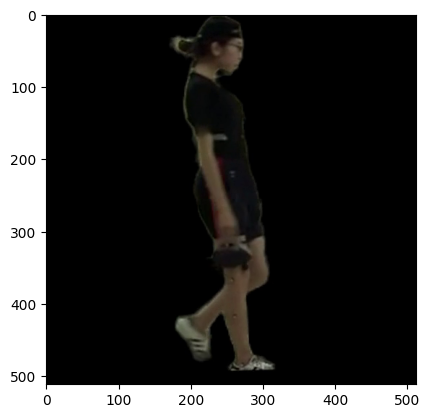

In [28]:
plt.imshow(vframes[22])